# COVID-19 Predictions

Before anything. I'd like to disclose that I'm nowhere near close to an epidemiologist. I am a Master's Student at University of Toronto working on Deep Learning based Recommendation System. With that said, most of the studies, commentaries and conclusions in this work are the results of my own experience with machine learning as well as some online articles and some very shallow research, but most come from basic math and stats knowledge.

These results are not the actual results. I am just posting this to encourage others. I trully believe we can always make better decisions when we have data on our side. This is my attempt on helping somehow.

### Data
The White House Office of Science and Technology Policy (OSTP) pulled together a coalition research groups and companies (including Kaggle) to prepare the COVID-19 Open Research Dataset (CORD-19) to attempt to address key open scientific questions on COVID-19. Those questions are drawn from National Academies of Sciences, Engineering, and Medicine’s (NASEM) and the World Health Organization (WHO).

In [84]:
import matplotlib.pyplot as plt
import numpy as np 
import os
import pandas as pd
import seaborn as sns
import warnings

from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Package configuration #

pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
warnings.filterwarnings('ignore')
%matplotlib inline

In [85]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('submission.csv')

df = pd.concat([train, test])

global_cases = train.groupby('Date')['ConfirmedCases'].sum()
global_deaths = train.groupby('Date')['Fatalities'].sum()

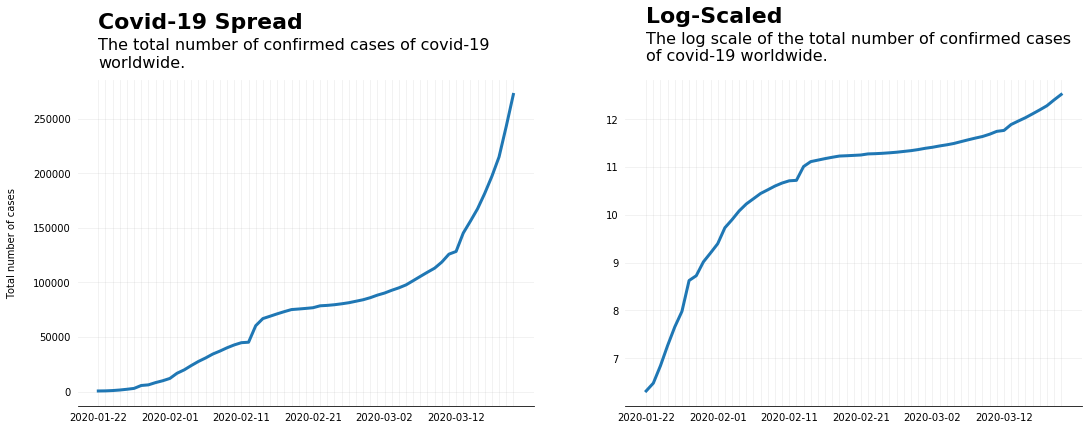

In [86]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))


## Code for plot 1 ##

sns.lineplot(x=global_cases.index, y=global_cases.values, linewidth=3, ax=ax[0])

sns.despine(top=True, left=True)

ax[0].grid(axis='both', alpha=.2)

every_nth = 10
for n, label in enumerate(ax[0].xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        
ax[0].tick_params(axis='both', which='both', bottom=False, left=False)

ax[0].text(x=0, y=max(global_cases.values)+60000, s='Covid-19 Spread', fontsize=22, fontweight='bold')
ax[0].text(x=0, y=max(global_cases.values)+25000, s='The total number of confirmed cases of covid-19 \nworldwide.', fontsize=16)
ax[0].set_xlabel('')

ax[0].set_ylabel('Total number of cases\n')

## Code for plot 2 ##

sns.lineplot(x=global_cases.index, y=np.log(global_cases.values), linewidth=3, ax=ax[1])

sns.despine(top=True, left=True)

ax[1].grid(axis='both', alpha=.2)

every_nth = 10
for n, label in enumerate(ax[1].xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        
ax[1].tick_params(axis='both', which='both', bottom=False, left=False)

ax[1].text(x=0, y=max(np.log(global_cases.values))+1.5, s='Log-Scaled', fontsize=22, fontweight='bold')
ax[1].text(x=0, y=max(np.log(global_cases.values))+.70, s='The log scale of the total number of confirmed cases \nof covid-19 worldwide.', fontsize=16)
ax[1].set_xlabel('')

plt.show()

From the chart above, we can clearly see the exponential trend of the disease, and we can also see that the spread seemed to be slowing down a big at the beginning of march, until it began accelerating again, as can be seen in the semi-logarithmic chart on the right.

In the real world, true exponentials do not exist. The imporant thing when trying to understand the development of the disease is to understand if we are past or behind the inflection point.The inflection point is the point right in the middle of the logistic curve, where the disease will start slowing down until it reaches full stop.

The Growth Factor is the ratio between the number of cases one day and the number of cases in the previous day. It shows us if the disease is growing or not. 

    1.Growth Factor = 1 (Number of cases isn't growing) => Inflection Point
    2.Growth Factor < 1 (Number of cases decreasing)
    3.Growth Factor > 1 (Number of cases increasing)


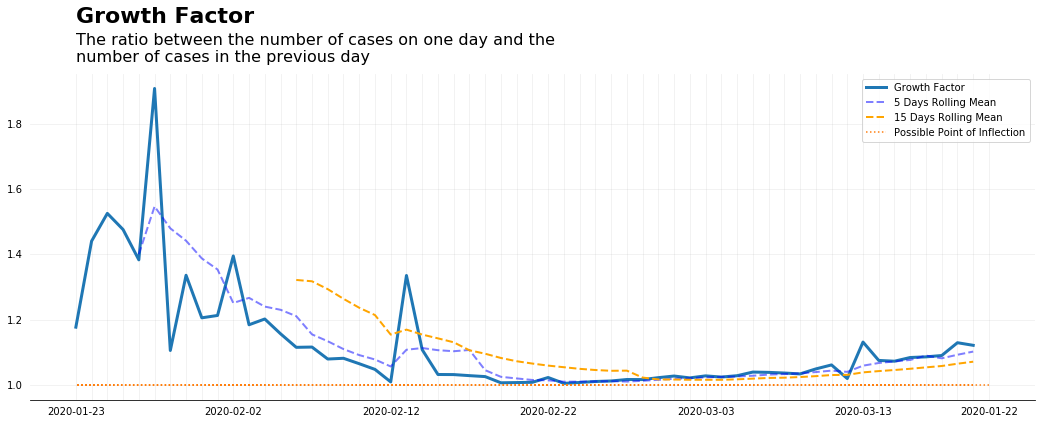

In [87]:
g = global_cases/global_cases.shift(1)


fig, ax = plt.subplots(figsize=(18, 6))
                       
sns.lineplot(x=g.index, y=g.values, linewidth=3, ax=ax)
sns.lineplot(x=g.index, y=g.rolling(5).mean().values, linewidth=2, ax=ax, color='blue', alpha=.5)
sns.lineplot(x=g.index, y=g.rolling(15).mean().values, linewidth=2, ax=ax, color='orange')

sns.despine(top=True, left=True)

ax.grid(axis='both', alpha=.2)

every_nth = 10
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        
ax.tick_params(axis='both', which='both', bottom=False, left=False)

ax.text(x=0, y=max(g.fillna(0)) + .20, s='Growth Factor', fontsize=22, fontweight='bold')
ax.text(x=0, y=max(g.fillna(0)) + .08, s='The ratio between the number of cases on one day and the\nnumber of cases in the previous day', fontsize=16)

sns.lineplot(x=g.index, y=np.ones(len(g)), ax=ax)
ax.lines[1].set_linestyle('dashed')
ax.lines[2].set_linestyle('dashed')
ax.lines[3].set_linestyle(':')
ax.legend(['Growth Factor', '5 Days Rolling Mean', '15 Days Rolling Mean', 'Possible Point of Inflection'])
ax.set_xlabel('')

plt.show()

We can see in the chart that at mid february we were very close to beeing at the point of inflection but after that we can see that the trend is going up.

### Baseline - Linear Regression

In [88]:
x = np.arange(0, len(global_cases)).reshape(-1, 1)
y = np.log(global_cases.values)

model = LinearRegression().fit(x, y)

print('R-Squared: %s' % model.score(x, y))

R-Squared: 0.7704062276422439


Based on the logarithmic scale of the number of cases we are able to fit a linear regression pretty well with a R-Squared of .77

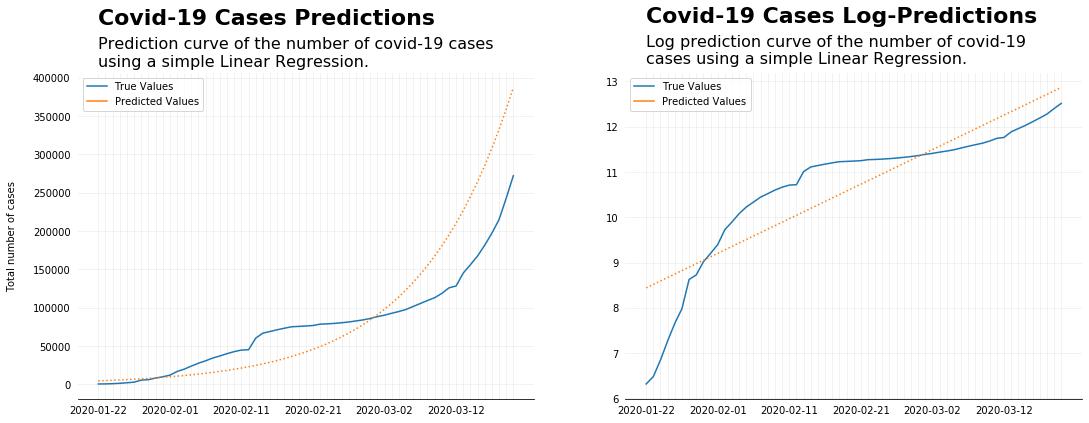

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

## Code for plot 1 ##

sns.lineplot(global_cases.index, np.exp(y), ax=ax[0])
sns.lineplot(global_cases.index, np.exp(model.predict(x)), ax=ax[0])

ax[0].grid(axis='both', alpha=.2)

sns.despine(top=True, left=True)

every_nth = 10
for n, label in enumerate(ax[0].xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        
ax[0].text(x=0, y=470000, s='Covid-19 Cases Predictions', fontsize=22, fontweight='bold')
ax[0].text(x=0, y=415000, s='Prediction curve of the number of covid-19 cases\nusing a simple Linear Regression.', fontsize=16)
        
ax[0].tick_params(axis='both', which='both', bottom=False, left=False)
ax[0].legend(['True Values', 'Predicted Values'])
ax[0].set_xlabel('')
ax[0].lines[1].set_linestyle(':')

ax[0].set_ylabel('Total number of cases\n')
        
## Code for plot 2 ##

sns.lineplot(global_cases.index, np.log(global_cases.values), ax=ax[1])
sns.lineplot(global_cases.index, model.predict(x), ax=ax[1])

ax[1].grid(axis='both', alpha=.2)

sns.despine(top=True, left=True)

every_nth = 10
for n, label in enumerate(ax[1].xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        
ax[1].text(x=0, y=14.3, s='Covid-19 Cases Log-Predictions', fontsize=22, fontweight='bold')
ax[1].text(x=0, y=13.4, s='Log prediction curve of the number of covid-19\ncases using a simple Linear Regression.', fontsize=16)
        
ax[1].tick_params(axis='both', which='both', bottom=False, left=False)
ax[1].legend(['True Values', 'Predicted Values'])
ax[1].set_xlabel('')
ax[1].lines[1].set_linestyle(':')

plt.show()

### Simple Random Forest

In [90]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 10 decision trees
rf = RandomForestRegressor(n_estimators = 3, random_state = 42)

x = np.arange(0, len(global_cases)).reshape(-1, 1)
y = np.log(global_cases.values)

rf_model = rf.fit(x, y)

print('R-Squared: %s' % model.score(x, y))

R-Squared: 0.7704062276422439


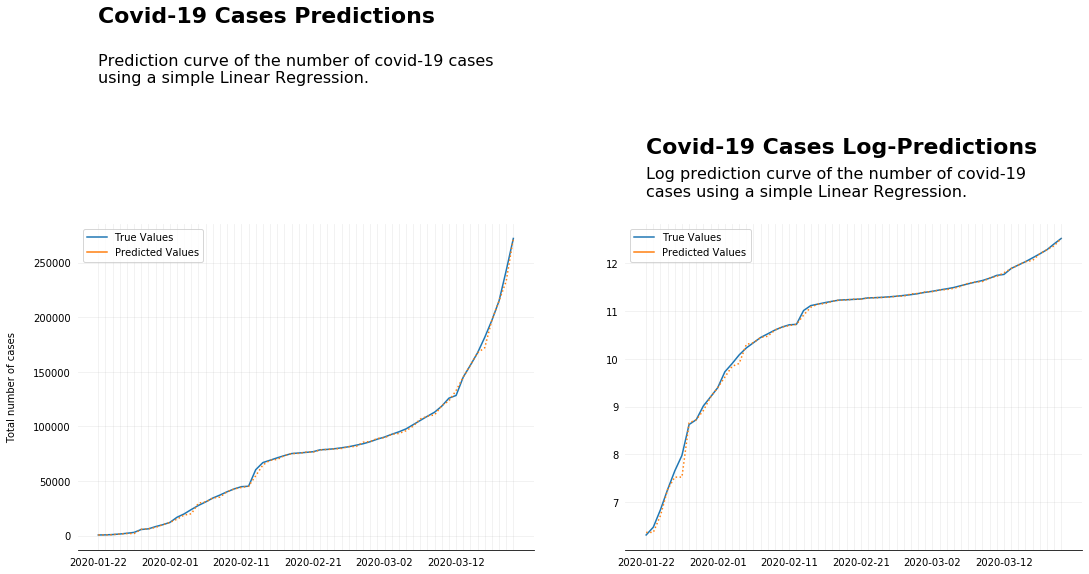

In [91]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

## Code for plot 1 ##

sns.lineplot(global_cases.index, np.exp(y), ax=ax[0])
sns.lineplot(global_cases.index, np.exp(rf_model.predict(x)), ax=ax[0])

ax[0].grid(axis='both', alpha=.2)

sns.despine(top=True, left=True)

every_nth = 10
for n, label in enumerate(ax[0].xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        
ax[0].text(x=0, y=470000, s='Covid-19 Cases Predictions', fontsize=22, fontweight='bold')
ax[0].text(x=0, y=415000, s='Prediction curve of the number of covid-19 cases\nusing a simple Linear Regression.', fontsize=16)
        
ax[0].tick_params(axis='both', which='both', bottom=False, left=False)
ax[0].legend(['True Values', 'Predicted Values'])
ax[0].set_xlabel('')
ax[0].lines[1].set_linestyle(':')

ax[0].set_ylabel('Total number of cases\n')
        
## Code for plot 2 ##

sns.lineplot(global_cases.index, np.log(global_cases.values), ax=ax[1])
sns.lineplot(global_cases.index, rf_model.predict(x), ax=ax[1])

ax[1].grid(axis='both', alpha=.2)

sns.despine(top=True, left=True)

every_nth = 10
for n, label in enumerate(ax[1].xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        
ax[1].text(x=0, y=14.3, s='Covid-19 Cases Log-Predictions', fontsize=22, fontweight='bold')
ax[1].text(x=0, y=13.4, s='Log prediction curve of the number of covid-19\ncases using a simple Linear Regression.', fontsize=16)
        
ax[1].tick_params(axis='both', which='both', bottom=False, left=False)
ax[1].legend(['True Values', 'Predicted Values'])
ax[1].set_xlabel('')
ax[1].lines[1].set_linestyle(':')

plt.show()

## Future Predictions

In [92]:
x_2 = np.arange(0, 79).reshape(-1, 1)

predictions_lr = model.predict(x_2)
predictions_rf = rf_model.predict(x_2)

In [93]:
first_date = pd.to_datetime(min(global_cases.index))
last_date =  (first_date + timedelta(days=78)).strftime('%Y-%m-%d')
first_date = first_date.strftime('%Y-%m-%d')
index = pd.date_range(first_date, last_date)

Linear Regression Predictions in upcoming months


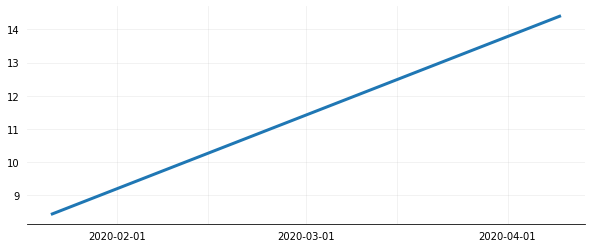

In [94]:
print('Linear Regression Predictions in upcoming months')
fig, ax = plt.subplots(figsize=(10, 4))
                       
sns.lineplot(x=index, y=predictions_lr, linewidth=3)

sns.despine(top=True, left=True)

ax.grid(axis='both', alpha=.2)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        
ax.tick_params(axis='both', which='both', bottom=False, left=False)


plt.show()


Random Forest Predictions in upcoming months


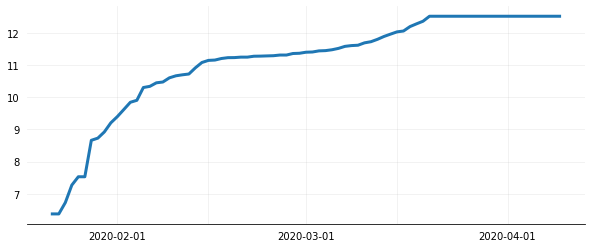

In [95]:
print('Random Forest Predictions in upcoming months')
fig, ax = plt.subplots(figsize=(10, 4))
                       
sns.lineplot(x=index, y=predictions_rf, linewidth=3)

sns.despine(top=True, left=True)

ax.grid(axis='both', alpha=.2)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        
ax.tick_params(axis='both', which='both', bottom=False, left=False)


plt.show()


Our linear regression and random forest model predicts that in 20 days we'll have almost 1.7 million people infected. This is obviously a very simple linear regression and random forest model using some very basic data. We could surely do a much better job using other features like, total population, infection probability etc. The model also doesn't take into consideration the measures taken by governments to reduce the spread of the infection and obviously it also doesn't take into account the development of medicine and vaccination.


# COVID-19 Stasticial Approach
[Research Paper](https://assets.tue.nl/fileadmin/content/pers/2020/03%20March/TUe%20-%20Technical_Report_Prediction_Corona_Virus.pdf)

Reimplementing the model proposed by researchers from TU Eindhoven in this notebook. They proposed to fit a simple sigmoid function to each of the measurements of a country:


E(Y_t) = M / (1 + exp (-𝛽 ( t - 𝛼 ) )



with M the maximal number of cases, 𝛼 the number of days at which the expected number of counts is half way the maximum,and 𝛽 > 0 the growth parameter.

**Special caution should be taken with exponential models such as these Sigmoid based models. I am not saying that this is the ideal approach.**



In [96]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_log_error
import warnings; warnings.filterwarnings('ignore')

# Load in our data

In [97]:
train = pd.read_csv('train.csv')
train['Date'] = pd.to_datetime(train['Date'])
test = pd.read_csv('test.csv')
test['Date'] = pd.to_datetime(test['Date'])
sub = pd.read_csv('submission.csv')
sub['ForecastId'] = test['ForecastId'].values
sub = sub.set_index('ForecastId', drop=True)
#train[train['Province/State']=='Ontario']

In [98]:
train['Province/State'][train['Country/Region']=='Canada'].unique()

array(['Alberta', 'British Columbia', 'Grand Princess', 'Manitoba',
       'New Brunswick', 'Newfoundland and Labrador', 'Nova Scotia',
       'Ontario', 'Prince Edward Island', 'Quebec', 'Saskatchewan'],
      dtype=object)

# Remove overlap between train and test set

In [99]:
# Only use data up to 11/03 to get a public LB score
print(len(train))
val = train[train["Date"] >= min(test['Date'])]
train = train[train["Date"] < min(test['Date'])]
print(len(train))

16756
14200


# Fit sigmoid model for each country / region combination

In [100]:
def sigmoid(t, M, beta, alpha):
    return M / (1 + np.exp(-beta * (t - alpha)))

sigmoid_models = {}
def forecast(data, steps, key=None):
    if sum(data) == 0 or sum(data != 0) <= 3:
        return [data[-1]] * steps
    
    filtered_data = data[data > 0]
    
    try:
        def error(params):
            M, beta, alpha = params
            return np.sqrt(mean_squared_log_error(filtered_data, sigmoid(list(range(sum(data == 0), len(data))), M, beta, alpha)))
        res = opt.minimize(error, x0=[1000, 0.25, 100])
        M, beta, alpha = res.x
        sigmoid_models[key] = (M, beta, alpha)
        return np.clip(sigmoid(list(range(len(data), len(data) + steps)), M, beta, alpha), 0, None).astype(int)
    except:
        try:
            popt, pcov = opt.curve_fit(sigmoid, list(range(sum(data == 0), len(data))), 
                                       filtered_data, maxfev=10000, p0=[1000, 0.25, 100])
            M, beta, alpha = popt
            sigmoid_models[key] = (M, beta, alpha)
            return np.clip(sigmoid(list(range(len(data), len(data) + steps)), M, beta, alpha), 0, None).astype(int)
        except:
            print(key)
            return [data[-1]] * steps
    


for country in tqdm_notebook(np.unique(train['Country/Region'])):
    country_data = train[(train['Country/Region'] == country)]
    country_data = country_data.sort_values(by='Date')
    if country not in ['US', 'China', 'Canada', 'Australia', 'France', 'United Kingdom', 'Netherlands', 'Denmark', 'Cruise Ship']:
        country_test_data = test[test['Country/Region'] == country].sort_values(by='Date')
        sub.loc[country_test_data['ForecastId'], 'ConfirmedCases'] = forecast(country_data['ConfirmedCases'].values, len(country_test_data), key=(country, np.NaN, 'ConfirmedCases'))
        sub.loc[country_test_data['ForecastId'], 'Fatalities'] = forecast(country_data['Fatalities'].values, len(country_test_data), key=(country, np.NaN, 'Fatalities'))
    else:
        for region in np.unique(country_data['Province/State']):
            region_data = country_data[country_data['Province/State'] == region]
            region_data = region_data.sort_values(by='Date')
            
            region_test_data = test[(test['Country/Region'] == country) & (test['Province/State'] == region)].sort_values(by='Date')
            sub.loc[region_test_data['ForecastId'], 'ConfirmedCases'] = forecast(region_data['ConfirmedCases'].values, len(region_test_data), key=(country, region, 'ConfirmedCases'))
            sub.loc[region_test_data['ForecastId'], 'Fatalities'] = forecast(region_data['Fatalities'].values, len(region_test_data), key=(country, region, 'Fatalities'))

# Plot some of our fitted models

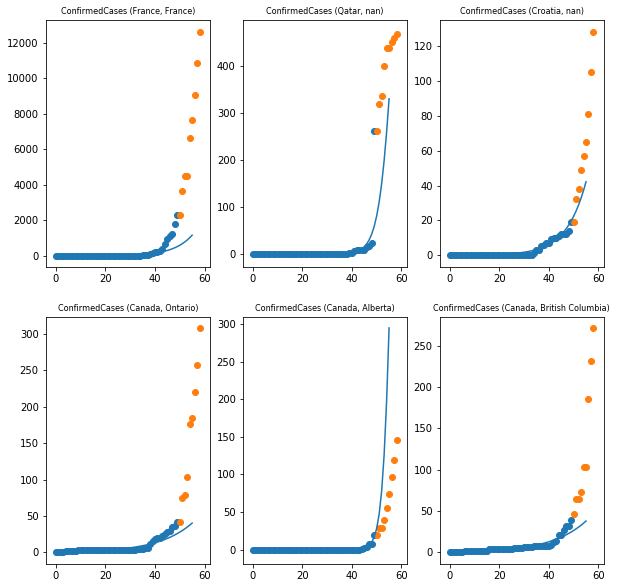

In [101]:
random_key_ix = list(np.random.choice(list(range(len(sigmoid_models))), 3, replace=False))
random_keys=[list(sigmoid_models.keys())[ix] for ix in random_key_ix] + [('Canada', 'Ontario', 'ConfirmedCases'), ('Canada', 'Alberta','ConfirmedCases'), ('Canada', 'British Columbia', 'ConfirmedCases')]
f, ax = plt.subplots(2, 3, figsize=(10, 10))
for i, key in enumerate(random_keys):
    country, region, task = key
    
    filtered_data = train[(train['Country/Region'] == country)]
    if not pd.isnull(region):
        filtered_data = filtered_data[(filtered_data['Province/State'] == region)]
        
    filtered_eval_data = val[(val['Country/Region'] == country)]
    if not pd.isnull(region):
        filtered_eval_data = filtered_eval_data[(filtered_eval_data['Province/State'] == region)]
        
    x = list(range(len(country_data)))
  
    x += list(range(len(x), len(x) + 6))
    
    
    M, beta, alpha = sigmoid_models[key]
    ax[i // 3][i % 3].plot(x, sigmoid(x, M, beta, alpha))
    ax[i // 3][i % 3].scatter(list(range(len(filtered_data))), filtered_data[task].values)
    ax[i // 3][i % 3].scatter(list(range(len(filtered_data), len(filtered_data) + len(filtered_eval_data))), filtered_eval_data[task].values)
    ax[i // 3][i % 3].set_title('{} ({}, {})'.format(task, country, region), fontsize=8)

    
plt.show()
    

[Data](https://www.kaggle.com/c/covid19-global-forecasting-week-1)
[Reference 1](https://assets.tue.nl/fileadmin/content/pers/2020/03%20March/TUe%20-%20Technical_Report_Prediction_Corona_Virus.pdf)
[Reference 2](https://towardsdatascience.com/random-forest-in-python-24d0893d51c0)
[Reference 3](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
[Reference 4](https://www.kaggle.com/group16/sigmoid-per-country#Plot-some-of-our-fitted-models)
[Reference 5](https://www.kaggle.com/erichamers/millions-of-cases-in-20-days-covid-19-prediction)
